In [3]:
# %matplotlib agg
%matplotlib inline
import pandas as pd
import numpy as np
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from materials import seg_cmap, raw_scatter, data_aug, select_ensemble, best_idx, strong_idx, mid_idx, weak_idx, MLPs_predict, grid_3d, style_corr_bar
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE

## Preparing Data

In [4]:
df_all = pd.read_csv('adhesion_raw.csv')
df_all_att = pd.read_csv('mtt_raw.csv')

## Plot Raw Data

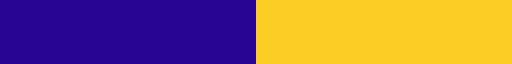

In [5]:
# Define cmap
plasma_seg = seg_cmap(cmap_name='plasma', value_range=(0.05, 0.9), num_colors=256, alpha=1.0, segments=2)
plasma_seg

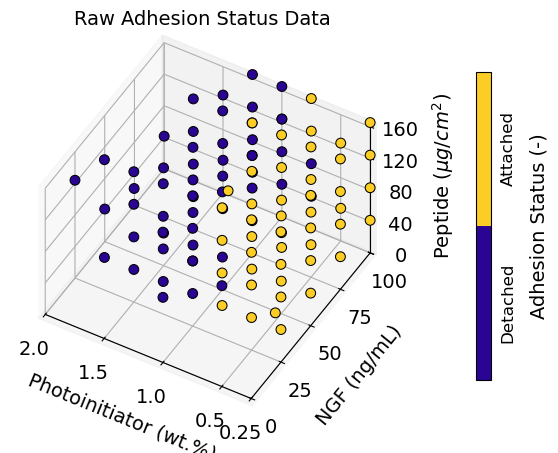

In [6]:
raw_plot = raw_scatter(df_all, azim=120, y_label='Adhesion', cmap=plasma_seg, elev=45, linewidths=0.75, 
                       cbar_label='Adhesion Status (-)', cpad=0.13, labels=True, zticks=[0, 40, 80, 120, 160])
plt.show()

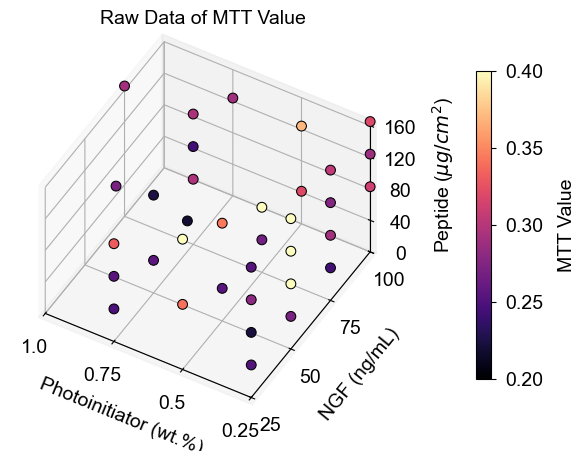

In [7]:
raw_scatter(df_all_att, vmin=0.2, vmax=0.4, azim=120, elev=45, linewidths=0.75, cbar_label='MTT Value', y_label='MTT Value',
            cpad=0.13, cmap='magma', xticks=[0.25, 0.50, 0.75, 1.0], yticks=[25, 50, 75, 100], 
            zticks=[0, 40, 80, 120, 160], cbarticks=[0.2, 0.25, 0.3, 0.35, 0.4], detatch=False, 
            title='Raw Data of MTT Value', labels=True)
plt.show()

## Normalize and Split Data to Training/Testing Sets

In [8]:
# Normalize x to 0-1 for classification
x_cols = ['PHO (wt.%)', 'NGF (ng/mL)', 'LAM (ug/cm2)']
y_cols = ['Neurite', 'MTT Value']
x_std_cols = ['PHO_std', 'NGF_std', 'LAM_std']
x_std_cols_mtt = ['PHO_std', 'NGF_std', 'LAM_std', 'MTT_std']

from sklearn.preprocessing import MinMaxScaler
scaler_clf = MinMaxScaler()
scaler_mtt = MinMaxScaler()
clf_scaled = scaler_clf.fit_transform(df_all[x_cols])
mlps_x_scaled = scaler_clf.transform(df_all_att[x_cols])
mlps_y_scaled = scaler_mtt.fit_transform(df_all_att[y_cols[1]].values.reshape(-1, 1))
df_std_clf = pd.DataFrame(clf_scaled, columns=x_std_cols)
df_std_clf['Adhesion'] = df_all['Adhesion']
df_std_att = pd.DataFrame(np.column_stack([mlps_x_scaled, mlps_y_scaled]), columns=x_std_cols_mtt)

In [9]:
# Train Test split for SVC
from sklearn.model_selection import RepeatedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

x_cols_std = ['PHO_std', 'NGF_std', 'LAM_std']
y_cols_std = ['Adhesion', 'MTT_std']
X = df_std_clf[x_cols_std]
y = df_std_clf[y_cols_std[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=34) # random state 34 is gppd

## Data Augmentation

In [11]:
df_clf_train = pd.concat([X_train, y_train], axis=1)
df_clf_test = pd.concat([X_test, y_test], axis=1)

# 10x for SVM classifier
df_clf_aug_train = data_aug(df_clf_train, features=['PHO_std', 'NGF_std', 'LAM_std'], 
                      y_aug=False, y_label='MTT_std', adhesion=True, num_aug=10, fnoise=0.05, ynoise=0.05, 
                      random_state=1)

# 20x for ensemble MLP
df_att_aug = data_aug(df_std_att, features=['PHO_std', 'NGF_std', 'LAM_std'], 
                   y_aug=True, y_label='MTT_std', adhesion=False, num_aug=20, fnoise=0.05, ynoise=0.05,
                   random_state=1)

## Train SVM Models

In [12]:
import joblib
svc = svm.SVC(C=0.1, gamma=0.1)

noaug_clf2 = svc.fit(X_train, y_train.values)
y_pred_train_noaug = noaug_clf2.predict(X_train)
y_pred_test_noaug = noaug_clf2.predict(X_test)
accuracy_train_noaug = accuracy_score(y_train, y_pred_train_noaug)
accuracy_test_noaug = accuracy_score(y_test, y_pred_test_noaug)
print(f'No augmentation SVC training accuracy = {accuracy_train_noaug:.4f}')
print(f'No augmentation SVC testing accuracy = {accuracy_test_noaug:.4f}')

# SVM with hyperparameter optimization and data augmentation
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10]
}

svc = svm.SVC()
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(df_clf_aug_train[x_cols_std], df_clf_aug_train[y_cols_std[0]].values)
best_clf = grid_search.best_estimator_
# joblib.dump(best_clf, 'best_svc_model.joblib')
y_pred_train = best_clf.predict(df_clf_aug_train[x_cols_std])
y_pred_test = best_clf.predict(X_test)
accuracy_train = accuracy_score(df_clf_aug_train[y_cols_std[0]], y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(f'With augmentation SVC training accuracy = {accuracy_train:.4f}')
print(f'With augmentation SVC testing accuracy = {accuracy_test:.4f}')

No augmentation SVC training accuracy = 0.5604
No augmentation SVC testing accuracy = 0.4545
With augmentation SVC training accuracy = 0.9870
With augmentation SVC testing accuracy = 0.9091


## Constructing Ensemble ANN

In [13]:
selected_models = {}

idxs = {
    'best_mlps': best_idx,
    'strong_mlps': strong_idx,
    'mid_mlps': mid_idx,
    'weak_mlps': weak_idx
}

for model_name, idx_value in idxs.items():
    selected_models[model_name] = select_ensemble(X, y, idx=idx_value)
    joblib.dump(selected_models[model_name], f'mlps_{model_name}.joblib')

In [ ]:
base_MLPs = []
r2_scores = []
maes = {}
X = df_att_aug[x_cols_std]
y = df_att_aug[y_cols_std[1]].values.flatten()
models = ['best_mlps', 'strong_mlps', 'mid_mlps', 'weak_mlps']

for model in models:
    selected_model = selected_models[model]
    maes[model] = []
    for i in range(len(selected_model)):

        selected_model[i].fit(X, y)
        base_MLPs.append(selected_model[i])

        # Calculate the R² score
        y_pred = selected_model[i].predict(X)
        r2 = r2_score(y, y_pred)
        mae = MAE(y, y_pred)
        maes[model].append(mae)

        print(f"Train R² score of {model} {i+1}: {r2:.4f}")
        print(f"  Train MAE of {model}:   {mae:.4f}")
        
    joblib.dump(selected_model, f'mlps_{model}.joblib')
    print((f"  {model} average Train MAE:    {np.mean(maes[model]):.4f}"))

In [15]:
import copy
df_gd = grid_3d(cols=x_cols_std, num_points=201)
pred_clf = best_clf.predict(df_gd)
df_gd['clf_pred'] = pred_clf

pred_mlps = {}
models = ['best_mlps', 'strong_mlps', 'mid_mlps', 'weak_mlps']

for model in models:
    pred_mlps[model] = MLPs_predict(df_gd.loc[:,x_std_cols], models=selected_models[model])    
    df_gd[f'{model}_pred'] = pred_mlps[model]

df_pred = copy.deepcopy(df_gd)

In [16]:
# For clf heatmap
df_pred_denorm_clf = pd.DataFrame(scaler_clf.inverse_transform(df_pred.loc[:,x_cols_std]), columns=x_cols)
df_pred_denorm_clf['clf_predict'] = df_pred['clf_pred']

# For MTT heatmap
temp_x = scaler_clf.inverse_transform(df_pred.loc[:,x_cols_std])
mlps_pred_cols = df_pred.columns[4:]
temp_y = scaler_mtt.inverse_transform(df_pred.loc[:,mlps_pred_cols].values.reshape(-1, 4))
df_pred_denorm_mlps = pd.DataFrame(np.column_stack([temp_x, temp_y]), columns=x_cols + mlps_pred_cols.to_list())

## Plot Predicted Results via 3D Heatmaps

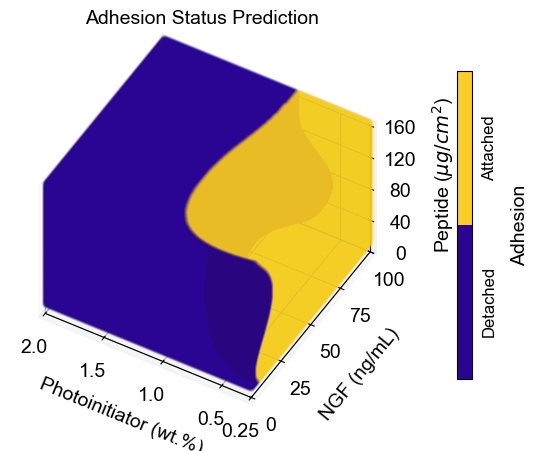

In [27]:
raw_scatter(df_pred_denorm_clf, features=x_cols, y_label='clf_predict', s=20, alpha=0.05, cmap=plasma_seg, marker='o', edgecolor='none', 
            linewidths=0, azim=120, elev=45, xticks=[0.25, 0.5, 1.0, 1.5, 2.0], zticks=[0, 40, 80, 120, 160], title='Adhesion Status Prediction',
            labels=True)
plt.show()

<Figure size 640x480 with 0 Axes>

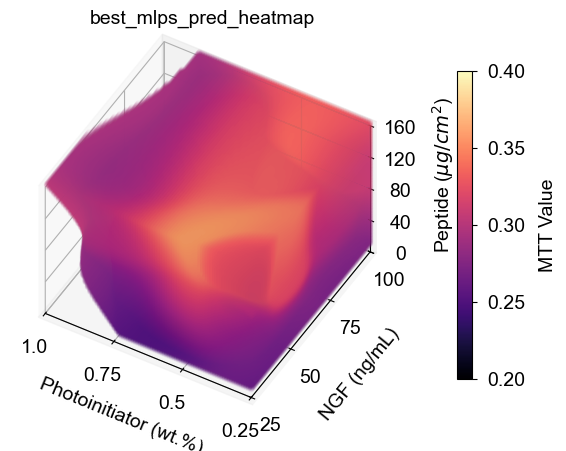

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

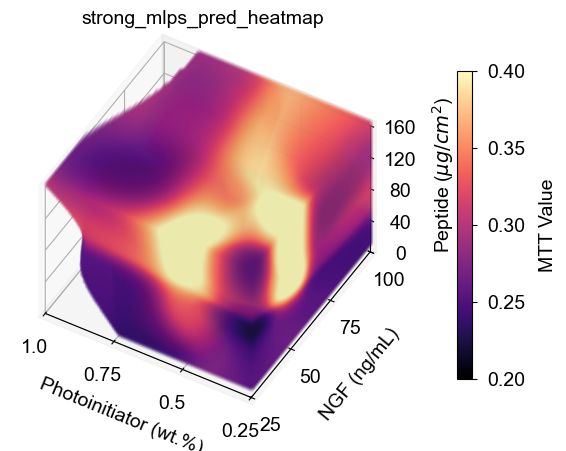

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

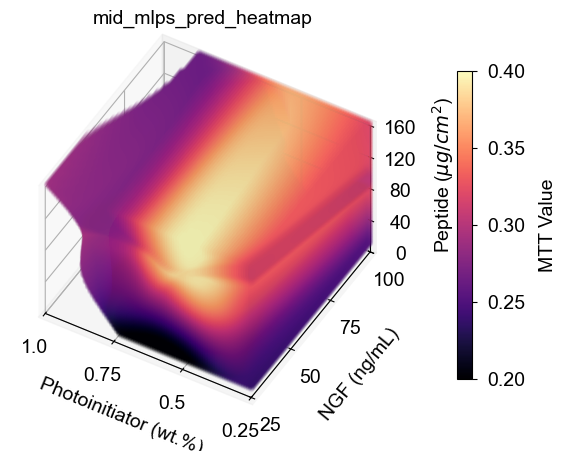

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

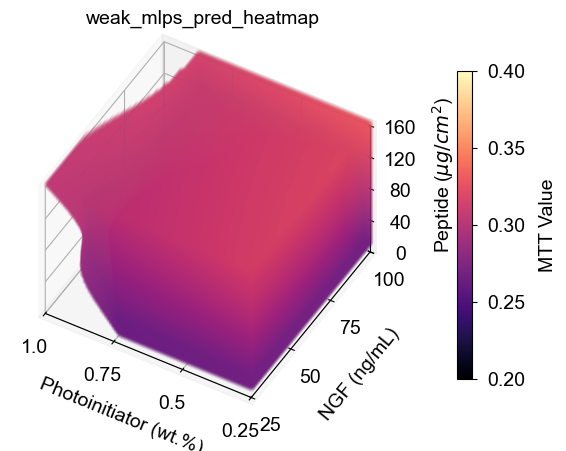

<Figure size 640x480 with 0 Axes>

In [21]:
mask = (df_pred_denorm_clf['clf_predict'] == True)
df_pred_denorm_mlps_m = df_pred_denorm_mlps[mask]
df_pred_denorm_mlps_filtered = df_pred_denorm_mlps_m[(df_pred_denorm_mlps_m['PHO (wt.%)'] <= 1.001) & (df_pred_denorm_mlps_m['NGF (ng/mL)'] >= 24.999) & (df_pred_denorm_mlps_m['LAM (ug/cm2)'] >= 10.299)]
y_labels = df_pred_denorm_mlps.columns.to_list()[3:]

for label in y_labels:
    plt.figure()
    raw_scatter(df_pred_denorm_mlps_filtered, vmin=0.2, vmax=0.4, features=x_cols, y_label=label, s=20, alpha=0.05, 
                marker='o', edgecolor='none', cbar_label='MTT Value', xticks=[0.25, 0.50, 0.75, 1.0], yticks=[25, 50, 75, 100], 
                zticks=[0, 40, 80, 120, 160], cbarticks=[0.2, 0.25, 0.3, 0.35, 0.4], labels=True,
                linewidths=0, cmap='magma', azim=120, elev=45, title=f'{label}_heatmap', detatch=False, cbar_alpha=1.0,
                )
    plt.show()
    plt.clf()

## Plot 2D Heatmaps for Best Models

In [22]:
from tqdm.auto import tqdm
import copy
import warnings
warnings.simplefilter("ignore", UserWarning)

n_points = 1001

xyz_columns = [
    ('PHO (wt.%)', 0.25, 1.0, [0.25, 0.50, 0.75, 1.0]),
    ('NGF (ng/mL)',   25, 100, [  25,   50,   75, 100]),
    ('LAM (ug/cm2)',    10.3, 165.3, [   10.3,  40,  80, 120, 160])
]

slices = [
    ('PHO (wt.%)', 0.5),
    ('NGF (ng/mL)', 75),
    ('LAM (ug/cm2)', 80),
]


pred_packages = {}

for slice_col, slice_val in tqdm(slices):
    (x_col, x_min, x_max, x_ticks), (y_col, y_min, y_max, y_ticks) = [info for info in xyz_columns if info[0] != slice_col]
    _x = np.linspace(x_min, x_max, num=n_points)
    _y = np.linspace(y_min, y_max, num=n_points)
    xx, yy = np.meshgrid(_x, _y)
    
    pred_df = pd.DataFrame()
    pred_df[x_col] = xx.reshape(-1)
    pred_df[y_col] = yy.reshape(-1)
    pred_df[slice_col] = slice_val
    pred_df = pred_df[x_cols]
    pred_df['Pred_Adhesion'] = best_clf.predict(scaler_clf.transform(pred_df[x_cols]))
    pred_df['Pred_MTT'] = MLPs_predict(scaler_clf.transform(pred_df[x_cols]), models=selected_models['best_mlps'])
    pred_df['Pred_MTT'] = scaler_mtt.inverse_transform(pred_df['Pred_MTT'].values.reshape(-1, 1))
    
    pred_packages[(slice_col, slice_val)] = (xx, yy, pred_df)    

  0%|          | 0/3 [00:00<?, ?it/s]

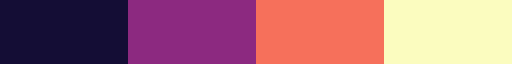

In [23]:
magma_seg = seg_cmap(cmap_name='magma', value_range=(0.1, 1.0), num_colors=256, alpha=1.0, segments=4)
magma_seg

  0%|          | 0/3 [00:00<?, ?it/s]

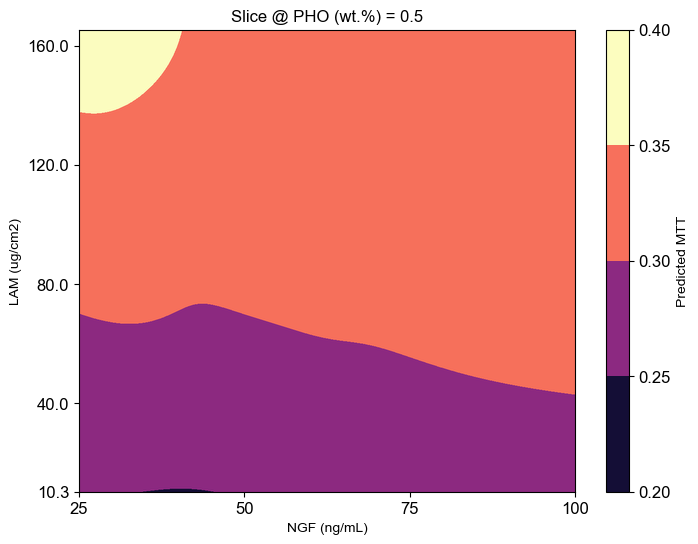

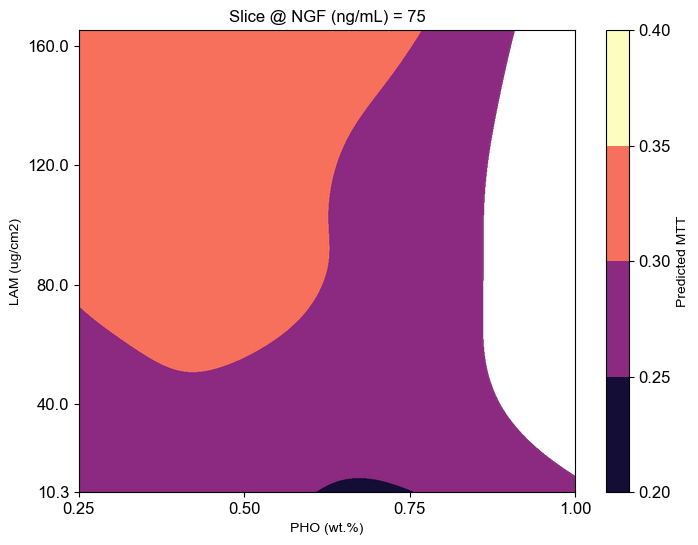

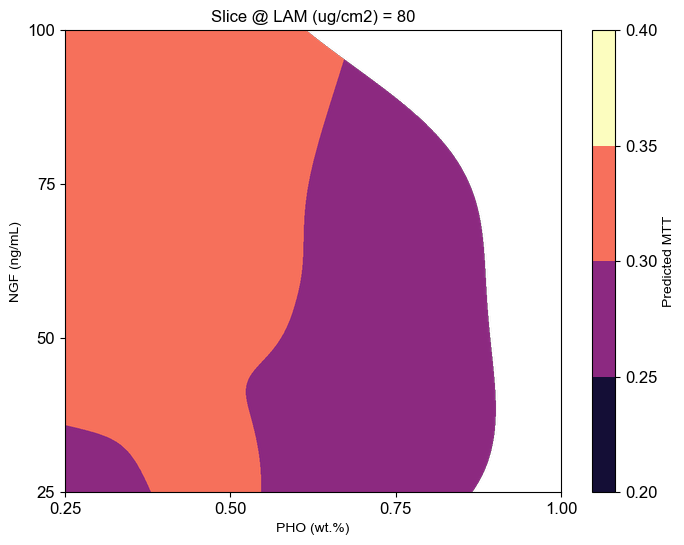

In [24]:
for slice_col, slice_val in tqdm(slices):
    (x_col, x_min, x_max, x_ticks), (y_col, y_min, y_max, y_ticks) = [info for info in xyz_columns if info[0] != slice_col]
    xx, yy, pred_df = pred_packages[(slice_col, slice_val)]

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    cc = copy.deepcopy(pred_df['Pred_MTT'].values).reshape(xx.shape)
    mask = pred_df['Pred_Adhesion'].values.reshape(xx.shape).astype(bool)
    cc[~mask] = np.nan

    im = ax.imshow(cc, cmap=magma_seg, vmin=0.2, vmax=0.4, aspect='auto',
              origin='lower', extent=(x_min, x_max, y_min, y_max), 
              interpolation='lanczos', interpolation_stage='rgba',
             )

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_title(f'Slice @ {slice_col} = {slice_val}')
    ax.tick_params(axis='both', which='both', labelsize=12)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Predicted MTT')
    cbar.set_ticks([0.2, 0.25, 0.3, 0.35, 0.4])
    cbar.ax.tick_params(labelsize=12)
    # fig.savefig(f'110124_slicevar_mix5_{slice_val}_2.png', dpi=300)

## Spearman's Analysis

In [25]:
from scipy.stats import spearmanr
import seaborn as sns

raw_x_cols = ['PHO (wt.%)', 'NGF (ng/mL)', 'LAM (ug/cm2)']

for df, y_col in [(df_all, 'Adhesion'), (df_all_att, 'MTT Value')]:
    print(spearmanr(df[raw_x_cols + [y_col]]))

raw_x_cols = ['PHO (wt.%)', 'NGF (ng/mL)', 'LAM (ug/cm2)']
r_x_cols = raw_x_cols[::-1]
p_color  = '#1F4D7D'
ax_color = 'k'

p_min = 0.001
r_min = 0.45

n_xcols = len(r_x_cols)
x_ticks = np.linspace(1, n_xcols, n_xcols)
x_lo, x_hi = 0.5, n_xcols + 0.5
bar_height = 0.3

def style_corr_bar(ax, legend_ncol=1, ):
    ax.plot([0, 0], [-1, n_xcols + 1],  linestyle='-', color=ax_color, lw=0.5)
    ax.plot([r_min, r_min], [-1, n_xcols + 1],  linestyle='--', color='grey', lw=0.5)
    ax.plot([-r_min, -r_min], [-1, n_xcols + 1],  linestyle='--', color='grey', lw=0.5)
    ax.set_xlabel('spearman $r$')
    ax.set_xticks([-1, -.5, 0, .5, 1])
    ax.set_xticklabels(['-1', '-0.5', '0', '0.5', '1'])
    ax.tick_params(axis='x', which='both')
    ax.set_xlim(-1, 1)
    ax.set_ylim(x_lo, x_hi)
    ax.set_yticks(x_ticks)
    ax.set_yticklabels(r_x_cols)
    ax.minorticks_off()
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=legend_ncol, fancybox=False, shadow=False)
    # fig.tight_layout()

SignificanceResult(statistic=array([[ 1.        , -0.04481901, -0.02672828, -0.84040643],
       [-0.04481901,  1.        , -0.04367758,  0.01204484],
       [-0.02672828, -0.04367758,  1.        ,  0.04034475],
       [-0.84040643,  0.01204484,  0.04034475,  1.        ]]), pvalue=array([[0.00000000e+00, 6.54661345e-01, 7.89728576e-01, 2.35000402e-28],
       [6.54661345e-01, 0.00000000e+00, 6.62914057e-01, 9.04362724e-01],
       [7.89728576e-01, 6.62914057e-01, 0.00000000e+00, 6.87239445e-01],
       [2.35000402e-28, 9.04362724e-01, 6.87239445e-01, 0.00000000e+00]]))
SignificanceResult(statistic=array([[ 1.        ,  0.00167862, -0.01550402, -0.17493796],
       [ 0.00167862,  1.        , -0.0013374 ,  0.15359982],
       [-0.01550402, -0.0013374 ,  1.        ,  0.39238288],
       [-0.17493796,  0.15359982,  0.39238288,  1.        ]]), pvalue=array([[0.        , 0.99236423, 0.92956108, 0.31483012],
       [0.99236423, 0.        , 0.99391636, 0.37834425],
       [0.92956108, 0.993916

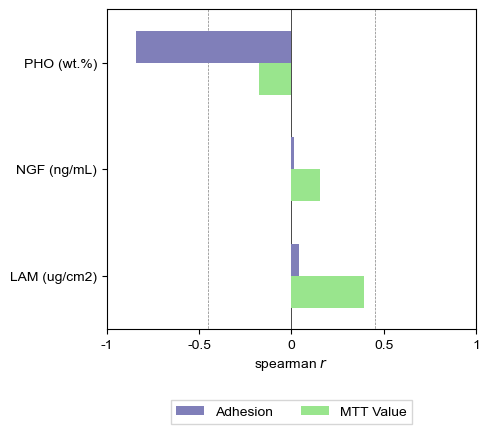

In [26]:
from scipy.stats import spearmanr
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(5, 4.5))

for i, (df, y_col, color) in enumerate([(df_all, 'Adhesion', '#807FB9', ), (df_all_att, 'MTT Value', '#99E58D', )]):
    corr = df[r_x_cols].corrwith(df[y_col], method='spearman')
    bars = ax.barh(x_ticks - (i - 0.5) * bar_height, corr, align='center', height=bar_height, color=color, label=y_col, zorder=300)

style_corr_bar(ax, legend_ncol=2, )
fig.tight_layout()
